https://www.kaggle.com/spscientist/students-performance-in-exams/home

Sınavlardaki performans cinsiyete, kökene ve anne-baba eğitim durumuna göre değişiklik göstermekte midir?

Öğle yemek tipinin sınav performansları ile bir ilişkisi var mı? Varsa bunu nasıl açıklayabilirsiniz?

Hazırlık kurslarının sonav performansı üzerinde bir etkisi var mı?

Birbiriyle korelasyonu en fazla olan dersler hangisidir?

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize

In [4]:
data = pd.read_csv("StudentsPerformance.csv")

In [5]:
data.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [7]:
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [10]:
data.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [15]:
data["math score"].value_counts()

65    36
62    35
59    32
69    32
73    27
      ..
22     1
19     1
18     1
8      1
0      1
Name: math score, Length: 81, dtype: int64

In [16]:
data["reading score"].value_counts()

72    34
74    33
64    32
73    30
67    30
      ..
32     1
28     1
26     1
23     1
17     1
Name: reading score, Length: 72, dtype: int64

In [17]:
data["writing score"].value_counts()

74    35
70    33
68    31
73    28
62    27
      ..
23     1
22     1
19     1
15     1
10     1
Name: writing score, Length: 77, dtype: int64

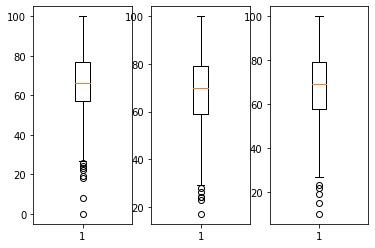

In [9]:
plt.subplot(1,3,1)
plt.boxplot(data["math score"])

plt.subplot(1,3,2)
plt.boxplot(data["reading score"])

plt.subplot(1,3,3)
plt.boxplot(data["writing score"])
plt.show()

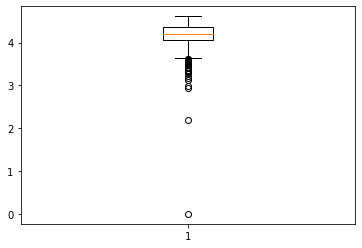

In [19]:
plt.boxplot(np.log((data["math score"])+1))
plt.show()


Burada aykırı değerleri min altını atabiliriz. Ya da winsorize edebiliriz. Ancak yukarıdaki sorular için şimdi bunlara dokunmayacağım.

Birbiriyle korelasyonu en fazla olan dersler hangisidir?

In [25]:
data.corr()

,math score,reading score,writing score,puan_ort
math score,1.000000,0.817580,0.802642,0.918746
reading score,0.817580,1.000000,0.954598,0.970331
writing score,0.802642,0.954598,1.000000,0.965667
puan_ort,0.918746,0.970331,0.965667,1.000000


<AxesSubplot:>

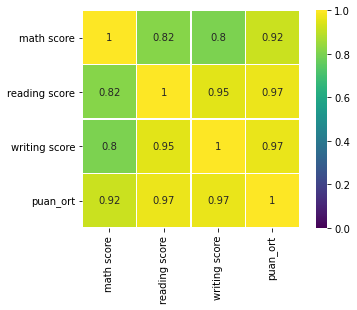

In [26]:
#reading ve writing arasında ki korelasyon daha fazla.
sns.heatmap(data.corr(), square=True, annot=True, linewidths=.5, vmin=0, vmax=1, cmap='viridis')

Sınavlardaki performans cinsiyete, kökene ve anne-baba eğitim durumuna göre değişiklik göstermekte midir?

Aşağıda bar plotlarda değişiklik göstermekte olduğunu görebiliriz.

In [20]:
#geneline bakmak için 3 dersin ortalamasını aldık.
data["puan_ort"] = (data["math score"] + data["reading score"] + data["writing score"])/3

<AxesSubplot:xlabel='gender'>

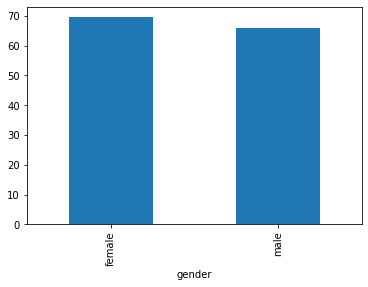

In [22]:
data.groupby("gender")["puan_ort"].mean().plot(kind="bar")

<AxesSubplot:xlabel='parental level of education'>

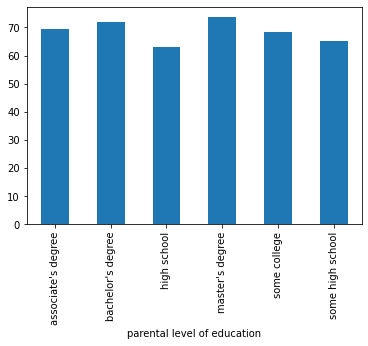

In [23]:
data.groupby("parental level of education")["puan_ort"].mean().plot(kind="bar")

<AxesSubplot:xlabel='race/ethnicity'>

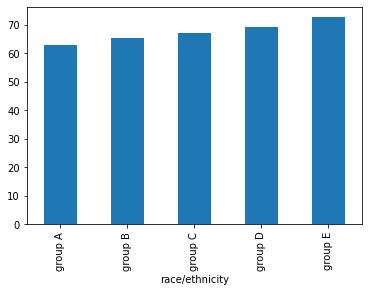

In [24]:
data.groupby("race/ethnicity")["puan_ort"].mean().plot(kind="bar")

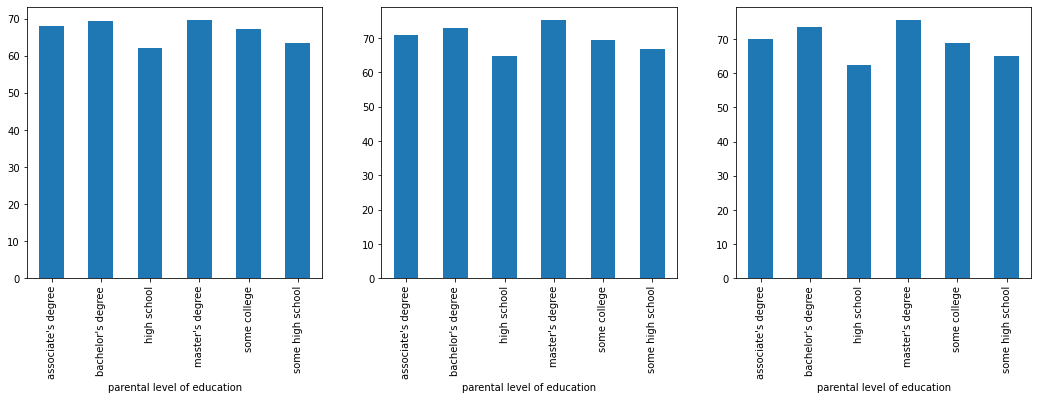

In [34]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
data.groupby("parental level of education")["math score"].mean().plot(kind="bar")

plt.subplot(1,3,2)
data.groupby("parental level of education")["reading score"].mean().plot(kind="bar")

plt.subplot(1,3,3)
data.groupby("parental level of education")["writing score"].mean().plot(kind="bar")
plt.show()


Masters degree olanların daha iyi olduğu,high_school olanların daha düşük olduğu görülüyor.

Yukarıdakini t testi ile de resmi olarak yorumlayalım.

In [37]:
# Test whether group differences are significant.
dereceler = data["parental level of education"].unique()

pd.options.display.float_format = '{:.15f}'.format
for var in ["math score", "reading score", "writing score"]:
    karsilastirma = pd.DataFrame(columns=['grup_1', 'grup_2','istatistik', 'p_degeri'])
    print("{} için karşılaştırma".format(var),end='')
    for i in range(0, len(dereceler)):
        for j in range(i+1, len(dereceler)):
            ttest = stats.ttest_ind(data[data["parental level of education"]==dereceler[i]][var], 
                                data[data["parental level of education"]==dereceler[j]][var])
            grup_1 = dereceler[i]
            grup_2 = dereceler[j]
            istatistik = ttest[0]
            p_degeri = ttest[1]
            
            karsilastirma = karsilastirma.append({"grup_1" : grup_1 ,
                                                  "grup_2" : grup_2 ,
                                                  "istatistik": istatistik , 
                                                  "p_degeri" : p_degeri}, ignore_index=True)
    display(karsilastirma)

math score için karşılaştırma

,grup_1,grup_2,istatistik,p_degeri
0,bachelor's degree,some college,1.370235282961748,0.171512242184716
1,bachelor's degree,master's degree,-0.148681965688493,0.881975782486770
2,bachelor's degree,associate's degree,0.878664188979324,0.380207578180362
3,bachelor's degree,high school,4.236143622484822,0.000029965345854
4,bachelor's degree,some high school,3.196718602676573,0.001540919292281
5,some college,master's degree,-1.235633421582457,0.217619568103474
6,some college,associate's degree,-0.542684269624753,0.587618280923407
7,some college,high school,3.546107949568116,0.000434980041925
8,some college,some high school,2.411704623140763,0.016324361572646
9,master's degree,associate's degree,0.841122968856347,0.400999363612466


reading score için karşılaştırma

,grup_1,grup_2,istatistik,p_degeri
0,bachelor's degree,some college,2.204882120908508,0.028127555314401
1,bachelor's degree,master's degree,-1.054085894947598,0.293296751317879
2,bachelor's degree,associate's degree,1.297796985045283,0.195242064830911
3,bachelor's degree,high school,5.017577900835298,0.000000880425031
4,bachelor's degree,some high school,3.403927067379874,0.000756197171973
5,some college,master's degree,-2.888843374950649,0.004165440800640
6,some college,associate's degree,-1.112318821691490,0.266600285399801
7,some college,high school,3.457842768362033,0.000600104848125
8,some college,some high school,1.714161972758909,0.087267868562439
9,master's degree,associate's degree,2.191201575983869,0.029264145709722


writing score için karşılaştırma

,grup_1,grup_2,istatistik,p_degeri
0,bachelor's degree,some college,2.680331468463220,0.007711012023673
1,bachelor's degree,master's degree,-0.999874130680484,0.318751964146466
2,bachelor's degree,associate's degree,2.115929663913376,0.035081624517197
3,bachelor's degree,high school,6.547380937127048,0.000000000240763
4,bachelor's degree,some high school,4.667733097498242,0.000004628198527
5,some college,master's degree,-3.168769063239491,0.001698593313596
6,some college,associate's degree,-0.761596864395391,0.446703166030366
7,some college,high school,4.488520877492127,0.000009275017803
8,some college,some high school,2.575721140379242,0.010358529086081
9,master's degree,associate's degree,2.781241549068550,0.005784032705258


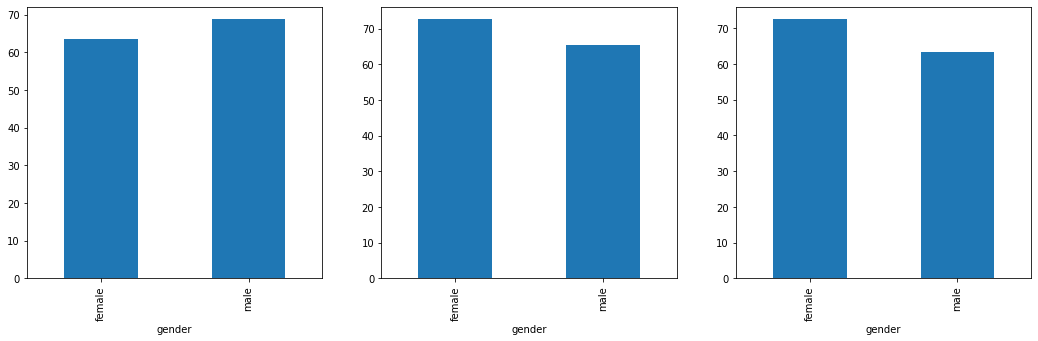

In [35]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
data.groupby("gender")["math score"].mean().plot(kind="bar")

plt.subplot(1,3,2)
data.groupby("gender")["reading score"].mean().plot(kind="bar")

plt.subplot(1,3,3)
data.groupby("gender")["writing score"].mean().plot(kind="bar")
plt.show()

#Cinsiyete göre farklılık gösteriyor diyemem birinde erkekler daha iyiyken diğerlerinde kızlar.

Öğle yemek tipinin sınav performansları ile bir ilişkisi var mı? Varsa bunu nasıl açıklayabilirsiniz?

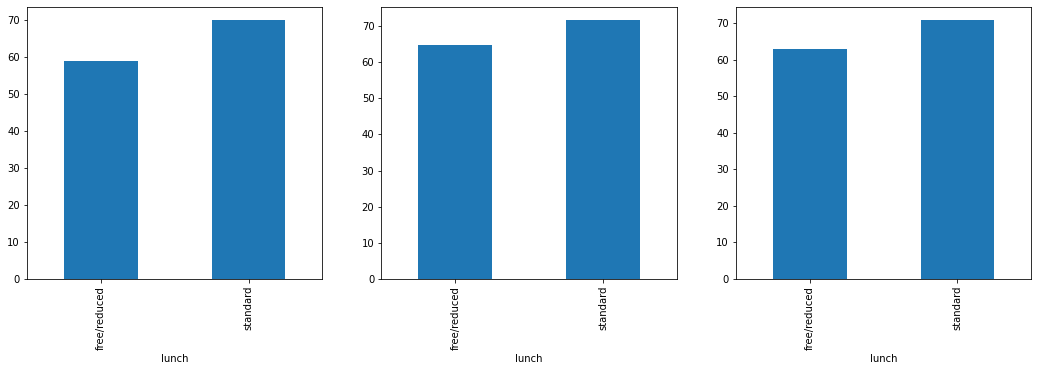

In [29]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
data.groupby("lunch")["math score"].mean().plot(kind="bar")

plt.subplot(1,3,2)
data.groupby("lunch")["reading score"].mean().plot(kind="bar")

plt.subplot(1,3,3)
data.groupby("lunch")["writing score"].mean().plot(kind="bar")
plt.show()

Standart yemek yiyen öğrencilerin başarısı daha yüksek görünüyor bunu istatiksel t veya anova testi ile de resmileştirebiliriz.

Hazırlık kurslarının sonav performansı üzerinde bir etkisi var mı?

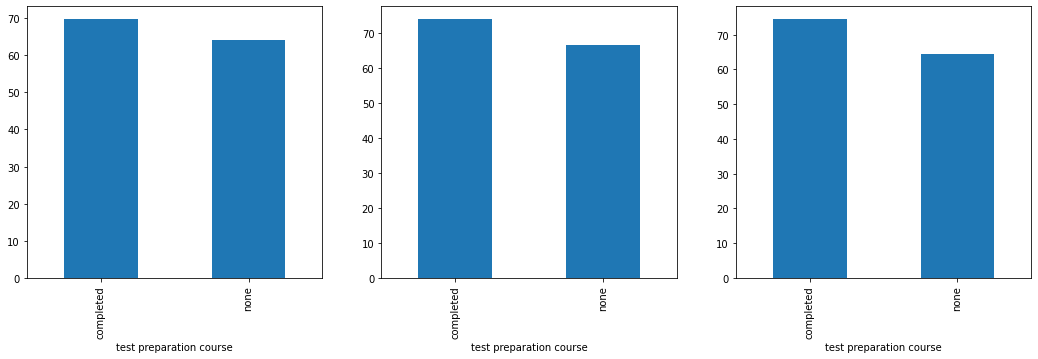

In [31]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
data.groupby("test preparation course")["math score"].mean().plot(kind="bar")

plt.subplot(1,3,2)
data.groupby("test preparation course")["reading score"].mean().plot(kind="bar")

plt.subplot(1,3,3)
data.groupby("test preparation course")["writing score"].mean().plot(kind="bar")
plt.show()

Aynı şekilde hazırlık kursu alanların notlarının daha yüksek olduğu görülür.